# Train AttractiveNet
a deep learning approach to regress on facial attractivness

In [38]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from alt_model_checkpoint.tensorflow import AltModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

import helper

In [54]:
# manually reload single modules if needed
import importlib
importlib.reload(helper)

In [ ]:
if tf.version.VERSION < '2.0':
    # TF1.X and older
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.log_device_placement = True
    sess = tf.Session(config=config)
    K.set_session(sess)
else:
    # TF2.X and newer
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    config.log_device_placement = True
    sess = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(sess)

## Data
Dataset Project: https://github.com/HCIILAB/SCUT-FBP5500-Database-Release

In [58]:
helper.download_data()

data already downloaded
data already extracted.


In [59]:
target_size = (350,350)

In [60]:
X,y = helper.create_dataset(target_size)

reading 5500 images into dataset


In [61]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=1/3, random_state=42)

In [62]:
print(f'train shape: {X_train.shape}, {y_train.shape}\nval shape: {X_val.shape}, {y_val.shape}\ntest shape: {X_test.shape}, {y_test.shape}')

train shape: (3850, 350, 350, 3), (3850,)
val shape: (1100, 350, 350, 3), (1100,)
test shape: (550, 350, 350, 3), (550,)


In [63]:
test_val_datagen = ImageDataGenerator()
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                  )

In [64]:
batch_size = 32

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = test_val_datagen.flow(X_val, y_val, batch_size=batch_size)
test_generator = test_val_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

## Model

In [65]:
model_name = 'attractiveNet_mnv2'
model_dir = 'models'

model_path= model_dir + '/' + model_name + '.h5'
if not os.path.isdir(model_dir): os.mkdir(model_dir)

In [66]:
basemodel = MobileNetV2(include_top=False, pooling='avg', weights='imagenet')

In [67]:
model = Sequential(name=model_name)
model.add(basemodel)
model.add(Dense(1))

## Training

## Stage 1

In [68]:
epochs = 30
lr=0.001

In [69]:
model.layers[0].trainable = False
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=lr))
print(model.summary())

parallel_model = multi_gpu_model(model, gpus=4)
parallel_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=lr))

Model: "attractiveNet_mnv2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [70]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        min_delta=1e-3,
        patience=7,
        verbose=1,
        ),
    AltModelCheckpoint(
        model_path,
        model,
        monitor='val_loss', 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=False, 
        )
]

In [ ]:
history1 = parallel_model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=len(y_train) // batch_size,
    validation_data=val_generator,
    verbose=1,
    callbacks = callbacks,
)

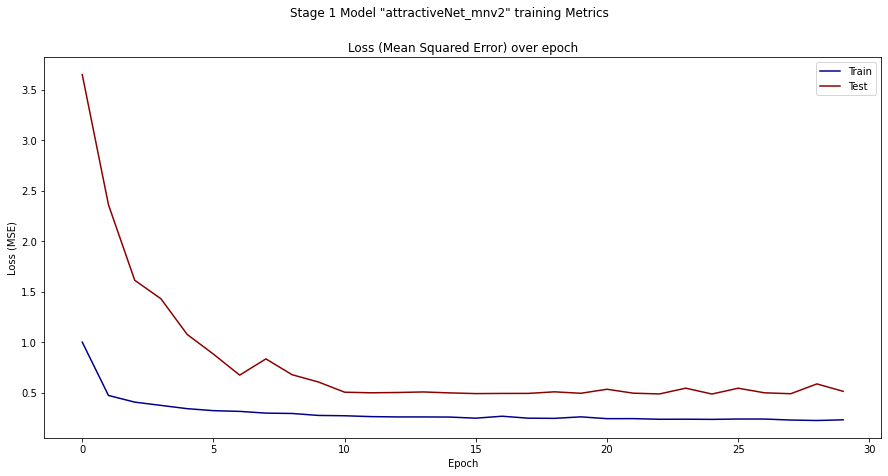

In [72]:
helper.plot_metrics(history1, model_name, 1)

## Stage 2

In [73]:
epochs = 30
lr=0.0001

In [74]:
model = load_model(model_path)
model.trainable = True
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=lr))
print(model.summary())

parallel_model = multi_gpu_model(model, gpus=4)
parallel_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=lr))

Model: "attractiveNet_mnv2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________
None


In [75]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        min_delta=1e-3,
        patience=7,
        verbose=1,
        ),
    AltModelCheckpoint(
        model_path,
        model,
        monitor='val_loss', 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=False, 
        )
]

In [ ]:
history2 = parallel_model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=len(y_train) // batch_size,
    validation_data=val_generator,
    verbose=1,
    callbacks = callbacks,
)

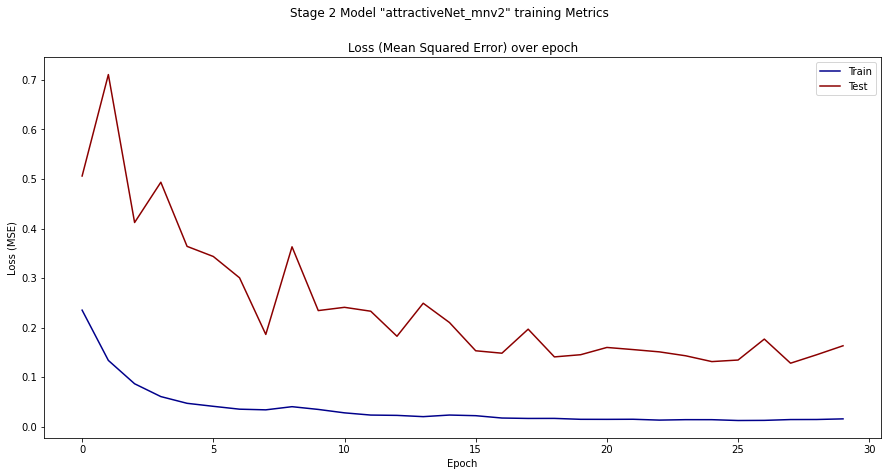

In [77]:
helper.plot_metrics(history2, model_name, 2)

## Test

In [78]:
model = load_model(model_path)

In [79]:
prediction = model.predict_generator(test_generator)

In [84]:
RMSE = mean_squared_error(y_test, prediction, squared=False)
MAE = mean_absolute_error(y_test, prediction)
print(f'RMSE: {RMSE}, MAE: {MAE}')

RMSE: 0.28585716016204066, MAE: 0.21198338088908802
